<a href="https://colab.research.google.com/github/RahulS247/Object-Localization/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

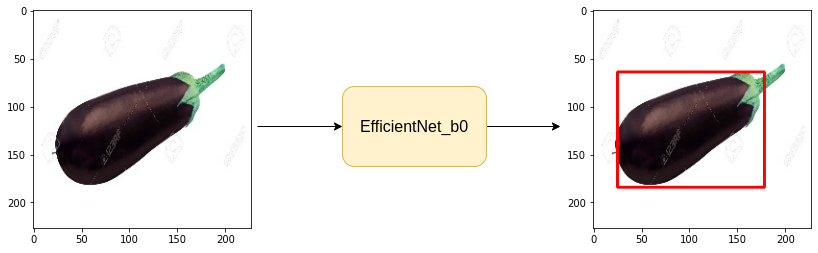

In [2]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-l3bddfr2
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-l3bddfr2
  Resolved https://github.com/albumentations-team/albumentations to commit 0cb8de5022a484e4586ce573040fc6e58885b094
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 48.9 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.1-py3-none-any.whl size=132541 sha256=92c3bc540fcc460d416d45a9b557bdd045a3b7a4641282f16474fd1460ba730d
  Stored in directory: /tmp/pip-ephem-wheel-cache-uztk23f8/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: scik

In [3]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [21]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import timm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [6]:
CSV_file = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
IMG_SIZE = 140

LR =0.001
EPOCHS = 40
MODEL_NAME ='efficientnet_b0'

NUM_COR = 4

In [7]:
df = pd.read_csv(CSV_file)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

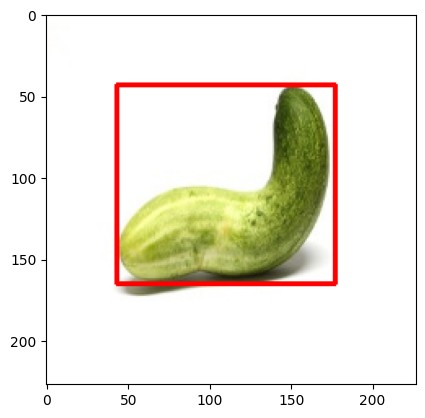

In [8]:
row = df.iloc[108]
img = cv2.imread(DATA_DIR+'/'+row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img=cv2.rectangle(img,pt1, pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

In [9]:
len(df)

186

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
len(train_df), len(valid_df)

(148, 38)

# Augmentations

In [11]:
import albumentations as A

In [12]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

# Create Custom Dataset

In [13]:
from torch.utils.data import Dataset, DataLoader
class ObjLocDataset(Dataset):
  def __init__(self,df,DATA_DIR,augmentations=None):
    self.df =df
    self.DATA_DIR = DATA_DIR
    self.augmentations = augmentations

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin=row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox=[[xmin,ymin,xmax,ymax]]

    imgpath = self.DATA_DIR+'/'+ row.img_path
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0
    bbox = torch.Tensor(bbox)

    return img, bbox

  def __len__(self):
    return len(self.df)

In [14]:
trainset = ObjLocDataset(train_df,DATA_DIR,train_augs)
validset= ObjLocDataset(valid_df,DATA_DIR,valid_augs)

In [15]:
len(trainset), len(validset)

(148, 38)

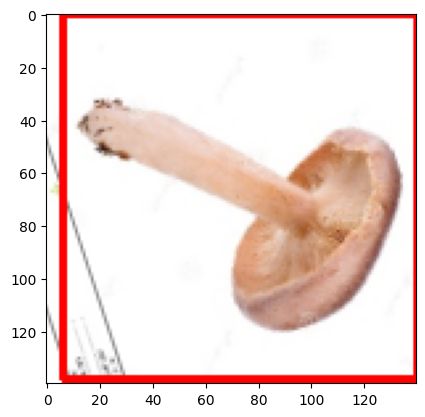

In [16]:
img, bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [17]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE,shuffle=False)

In [18]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [19]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [20]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel,self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)

  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)

    return bboxes



In [22]:
model = ObjLocModel()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

# Create Train and Eval Function

In [23]:
radom_img = torch.rand(1,3,140,140).to(DEVICE)
model(radom_img).shape

torch.Size([1, 4])

In [24]:
def train_fn(model, dataloader,optimizer):
  total_loss = 0.0
  model.train()
  for data in tqdm(dataloader):
    images,gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    pred = model(images)
    loss = loss_fn(pred, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()
  return total_loss/len(dataloader)

In [25]:
def valid_fn(model, dataloader):
  total_loss = 0.0
  model.eval()
  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      pred = model(images)
      loss = loss_fn(pred, gt_bboxes)

      total_loss +=loss.item()
    return total_loss/len(dataloader)

#Training Loop

In [26]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)
loss_fn = nn.MSELoss()

In [27]:
best_valid_loss = np.inf
train_losses =[]
valid_losses =[]

for epoch in range(EPOCHS):
  train_loss = train_fn(model,trainloader, optimizer)
  valid_loss = valid_fn(model,validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("saved")
    best_valid_loss = valid_loss

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  print(f"Epoch: {epoch+1} train loss: {train_loss}  valid_loss {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 1 train loss: 5226.013012695313  valid_loss 2900.5269368489585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 2 train loss: 1934.5451171875  valid_loss 2867.9148763020835


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 3 train loss: 996.5550384521484  valid_loss 407.92884318033856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 4 train loss: 746.9537200927734  valid_loss 196.84174092610678


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 5 train loss: 499.54880981445314  valid_loss 184.53988138834634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 6 train loss: 358.4281768798828  valid_loss 158.0208994547526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 train loss: 230.83695602416992  valid_loss 158.22445170084634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 8 train loss: 198.42700958251953  valid_loss 139.66974131266275


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 train loss: 157.72197341918945  valid_loss 194.11256408691406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 train loss: 126.24900665283204  valid_loss 155.0557123819987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 11 train loss: 111.33854522705079  valid_loss 103.08176167805989


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 12 train loss: 103.91944808959961  valid_loss 101.62002054850261


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 13 train loss: 100.96231613159179  valid_loss 86.99183909098308


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 train loss: 96.29730453491212  valid_loss 108.3906987508138


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 train loss: 94.65397262573242  valid_loss 159.04093424479166


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 train loss: 87.17298049926758  valid_loss 96.20332845052083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss: 81.45906677246094  valid_loss 137.667116800944


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 train loss: 75.2399242401123  valid_loss 149.09622701009116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss: 89.16052589416503  valid_loss 90.86666361490886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 20 train loss: 65.30074920654297  valid_loss 63.1845703125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 train loss: 55.30939483642578  valid_loss 74.30420939127605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss: 55.43569793701172  valid_loss 89.75516001383464


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 train loss: 58.24126758575439  valid_loss 67.26638539632161


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 train loss: 49.92439270019531  valid_loss 104.8255615234375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 train loss: 51.350036430358884  valid_loss 86.55168151855469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 train loss: 47.31801090240479  valid_loss 71.28254572550456


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss: 54.532363700866696  valid_loss 94.53406016031902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 train loss: 50.140835189819335  valid_loss 82.96248881022136


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 train loss: 52.2936897277832  valid_loss 102.10126368204753


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss: 57.924759483337404  valid_loss 106.1329574584961


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss: 50.5984806060791  valid_loss 86.3815205891927


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

saved
Epoch: 32 train loss: 46.89897556304932  valid_loss 56.386505126953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss: 46.65241374969482  valid_loss 58.97179412841797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss: 49.6996768951416  valid_loss 88.08233642578125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss: 39.08938751220703  valid_loss 76.92460123697917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss: 41.85180015563965  valid_loss 89.68076578776042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss: 51.96548919677734  valid_loss 56.65825398763021


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 train loss: 46.316092300415036  valid_loss 68.189879099528


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss: 42.624867057800294  valid_loss 61.3804079691569


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss: 32.34440517425537  valid_loss 71.87820688883464


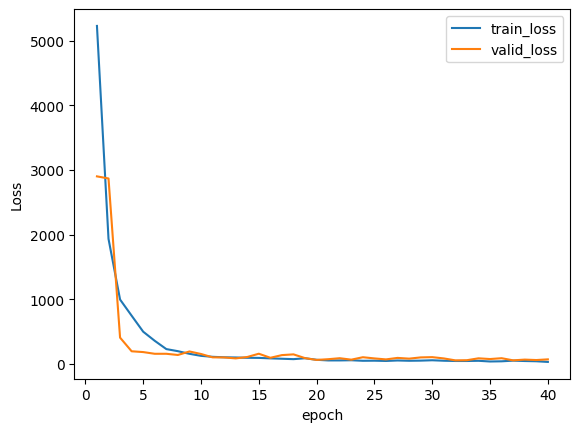

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1,EPOCHS+1),train_losses,label='train_loss')
plt.plot(range(1,EPOCHS+1),valid_losses,label='valid_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Inference

In [42]:
import utils
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

tensor([[ 22.6989,  23.6435, 118.4436,  93.3609]])


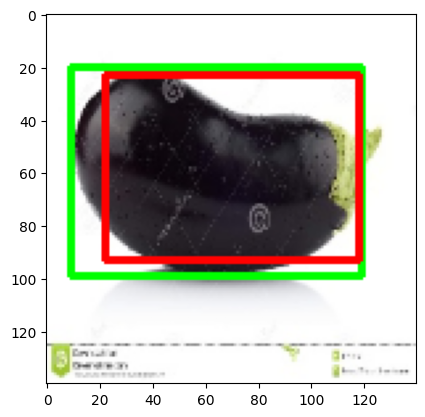

In [46]:
model.eval()
with torch.no_grad():
  image,gt_bbox = validset[13]
  pred = model(image.unsqueeze(0).to(DEVICE))
  print(pred)
  utils.compare_plots(image,gt_bbox,pred)
  # pt1 =(pred[0][0],pred[0][1])
  # pt2 =(pred[0][2],pred[0][3])
  # image = cv2.rectangle(image,pt1,pt2,(255,0,0),2)